# Imbalance classfication problem

The jupyter notebook includes all related algorithms and results for loading dataset, visualizing principal conponents, and, predicting the data's label using Logistic regression and a designed neural network. The problem will be examined several mehtods and ways.


## Introduction

Imbalanced classfication problem (Rare event prediction, Extreme event prediction, Severe class imbalance) refers to a class distribution that is inherently not balanced. As we will see, the classes distribution are not balanced.
 
There are perhaps two main groups of causes for the imbalance we may want to consider; they are data sampling and properties of the domain. Errors may have been made when collecting the observations. One type of error might have been applying the wrong class labels to many examples. Alternately, the processes or systems from which examples were collected may have been damaged or impaired to cause the imbalance.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


NUM_PCA_COMPONENT: int = 2
PCA_VARIANCE: np.float = 0.99
NUM_LDA_COMPONENT: int = 2


def get_data() -> List[pd.DataFrame]:
    input_train_data = pd.read_csv('train_x.csv')
    output_train_data = pd.read_csv('train_y.csv')
    input_test_data = pd.read_csv('test_x.csv')
    return input_train_data, output_train_data, input_test_data


def standardize_data(input_train_data: pd.DataFrame, input_test_data: pd.DataFrame) -> List[np.ndarray]:
    in_train = StandardScaler().fit_transform(input_train_data)
    in_test = StandardScaler().fit_transform(input_test_data)
    return in_train, in_test


def project_data(data: pd.DataFrame) -> pd.DataFrame:
    pca = PCA(n_components=NUM_PCA_COMPONENT)
    principalComponents = pca.fit_transform(data)
    principalDf = pd.DataFrame(data = principalComponents,
                                columns = ['principal component 1', 'principal component 2'])
    return principalDf, pca


def visualize_data_pca(final_df: pd.DataFrame) -> plt.plot:
    fig = plt.figure(figsize = (6,6))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    targets = [1, 0]
    colors = ['g', 'r']
    for target, color in zip(targets,colors):
        indicesToKeep = final_df['target'] == target
        ax.scatter(final_df.loc[indicesToKeep, 'principal component 1'],
                    final_df.loc[indicesToKeep, 'principal component 2'],
                    c = color,
                    s = 50)
    ax.legend(targets)
    ax.grid()


def visualize_data_lda(input_train_data: pd.DataFrame, out_train_data: pd.DataFrame) -> plt.plot:
    y = out_train_data.target
    X = input_train_data
    y.loc[4001] = y.loc[2] + 2
    X.loc[4001] = input_train_data.loc[0] * 10

    lda = LinearDiscriminantAnalysis(n_components=NUM_LDA_COMPONENT)
    # X_r = lda.fit(X, y).transform(X)
    X_lda = lda.fit_transform(X, y)
    colors = ['navy', 'red']
    target_names = ['False', 'True']
    plt.figure()
    for color, i, target_name in zip(colors, [0, 1], target_names):
        plt.scatter(X_lda[y == i, 0], X_lda[y == i, 1], alpha=.8, color=color,
                    label=target_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('2 LDA of data')
    plt.xlabel('LDA 1')
    plt.ylabel('LDA 2')
    plt.grid()
    plt.show()
    print("\n")
    print(f"The LDA variance ratios are {lda.explained_variance_ratio_}\n")

# Examining the possibility of exisiting imbalance in the dataset

In this step, the train data and test data will be loaded, then, we should examine the number of data in each classes to evaluate the possibility of existing imbalance between classes. Besides, the histogram of data will be plotted to examine the issue.

### Two types of Imbalance:

Slight Imbalance. An imbalanced classification problem where the distribution of examples is uneven by a small amount in the training dataset (e.g. 4:6).

Severe Imbalance. An imbalanced classification problem where the distribution of examples is uneven by a large amount in the training dataset (e.g. 1:100 or more).

#### Problem:

The minority class is harder to predict because there are few examples of this class, by definition.

There exists severe imablance!!



<AxesSubplot:title={'center':'Count (target)'}>

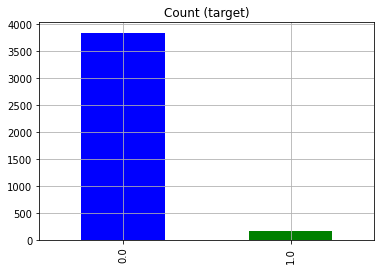

In [2]:
input_train_data, out_train_data, input_test_data = get_data()
data = input_train_data.copy()
data['target'] = out_train_data['target']
classes_ratio = (len(data[data['target'] == 1]) / len(data[data['target'] == 0]))
if classes_ratio <= 0.6:
    print("There exists severe imablance!!\n")
if classes_ratio >= 0.6 and classes_ratio <= 0.95:
    print("There exists slight imbalance!!\n")

data.target.value_counts().plot(kind='bar', title='Count (target)', color = ['b', 'g'], grid=True)

In [9]:
groups = data.groupby("target")
for name, group in groups:
    plt.plot(group[0], group[1], marker="o", linestyle="", label=name)
plt.legend()

KeyError: 0

As the figure above idicates, the frequency of classes is not balanced, and the first class (Target == zero) has much more samples than the other.

# Visualize Principal Components

The dataset should be normalized in order to avoid any problem not only in learning phase but also in computing principal components. Eventually, the data will be shown by considering principal components.

Since PCA yields a feature subspace that maximizes the variance along the axes, it makes sense to standardize the data, especially, if it was measured on different scales. The algorithm standardize approach is the transformation of the data onto unit scale (mean=0 and variance=1), which is a requirement for the optimal performance of many machine learning algorithms. Moreover, Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual feature do not more or less look like standard normally distributed data.

Here we plot the different samples on the 2 first principal components.

The pca's variance ratio is [0.18547859 0.0773893 ]



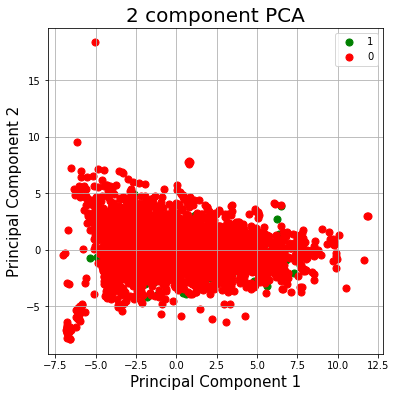

In [10]:
in_train, in_test = standardize_data(input_train_data, input_test_data)
principal_df, pca = project_data(in_train)
final_df = pd.concat([principal_df, out_train_data[['target']]], axis = 1)
visualize_data_pca(final_df)
print(f"The pca's variance ratio is {pca.explained_variance_ratio_}\n")

The plot of the dataset is created showing the large mass of examples for the majority class (red) and a small number of examples for the minority class (green), with some class overlap.

# Linear Discriminant Analysis (LDA)

LDA tries to identify attributes that account for the most variance between classes. In particular, LDA, in contrast to PCA, is a supervised method, using known class labels.

Teh plot of the dataset is created showing the large mass of examples for the majority class (blue) and a small number of examples for the minority class (red), with some class overlap

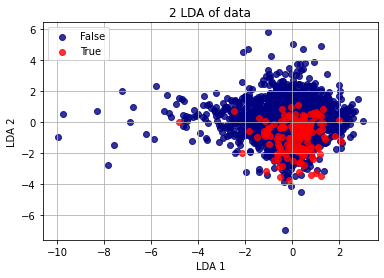



The LDA variance ratios are [0.99853512 0.00146488]



In [36]:
visualize_data_lda(input_train_data, out_train_data)

# Applying PCA to the Data
Principal Component Analysis (PCA) applied to this data identifies the combination of attributes (principal components, or directions in the feature space) that account for the most variance in the data. As defined in the first cell, the pcas' variance is 0.98, so there are forty five principal components for this value. By increasing its value, the number of principal components will increase and vice-versa.

In [11]:
pca = PCA(PCA_VARIANCE)
pca.fit(in_train)
print(f"Num of principal components is {pca.n_components_}\n")
train_ = pca.transform(in_train)
test_ = pca.transform(in_test)

Num of principal components is 45



# Logistic Regression

The fitting problem for train data will be computed by using Logistic Regression in this step. Then, the fitting accuracy will be computed for the seperated test data. Eventually, the target for the test data will be calculated using the obtained parameters in LogisticRegression. And, finally, the result is saved as a CSV file.

* accuracy (fraction of correct predictions): correct predictions / total number of data points

In [100]:
train_1, test_1, train_lbl, test_lbl = train_test_split(train_, out_train_data.target, test_size=1/5.0, random_state=0)
logisticRegr = LogisticRegression(solver = 'lbfgs')
logisticRegr.fit(train_1, train_lbl)

print(f"The prediction score on test:    {str(logisticRegr.score(test_1, test_lbl))}\n")
print(f"The prediction score on train:   {str(logisticRegr.score(train_1, train_lbl))}\n")

predicted_test = logisticRegr.predict(test_)
test_y = pd.DataFrame(predicted_test, columns=['target'])
test_y['Unnamed: 0'] = out_train_data['Unnamed: 0']
test_y = test_y[['Unnamed: 0', 'target']]
test_y.to_csv('test_y.csv')
test_y.head(8) 

The prediction score on test:    0.94875

The prediction score on train:   0.9621875



,Unnamed: 0,target
0,3915,0.0
1,4339,0.0
2,3422,0.0
3,5624,0.0
4,886,0.0
5,5936,0.0
6,3179,0.0
7,3969,0.0


## NOTES on Logisitic Regression:

1) The difference betweeen train score and test score is not significant, then, there does not exist any overfitting in the logistic regression fitting.

2) As the results of prediction clarify, all of the predicted targets are zero, which indicate that the logistic regression is not able to solve the imbalance classification problem, and causes the following problem. 

* The abundance of samples from the majority class can swamp the minority class. Most machine learning algorithms for classification predictive models are designed and demonstrated on problems that assume an equal distribution of classes. This means that a naive application of a model may focus on learning the characteristics of the abundant observations only, neglecting the examples from the minority class that is, in fact, of more interest and whose predictions are more valuable.

* The learning process of most classification algorithms is often biased toward the majority class examples, so that minority ones are not well modeled into the final system.

Hence, we are going to use deep learning methods to solve the problem.

# Neural Network (Deep Learning)

Deep learning uses an artificial neural network that uses multiple layers to progressively extract higher level features from the training data. We are using a simple three-layer network without any optimisation, except the usage of a small validation dataset. 


# Regularisation

In the following, I applied the 3 best practices for handling overfitting in a neural network:

1) reduce the network’s size

2) adding some weight regularisation

3) adding dropout

## Metrics

There are many metrics for evaluating how good a binary classifier is doing in predicting the class labels for instances/examples. Below are some caveats and suggestions for choosing and interpreting the appropriate metrics.

* Accuracy can be misleading. Since accuracy is simple the ratio of correctly predicted instances over all instances used for evaluation, it is possible to get a decent accuracy while having mostly incorrect predictions for the minority class.

* Confusion matrix helps break down the predictive performances on different classes.

Therefore, we utilize a combination of confusion matrix metrics and specifity-sensivity for solving the problem. Beside, we can compute the classes' weight, then use these weights for fitting problem in order to decrease imbalancing.

In [44]:
from keras import layers, models, optimizers, losses, metrics, regularizers, callbacks, initializers

bias_initializer = initializers.HeNormal()

NUM_VALIDATION: int = int(len(train_) * 0.2)

train_1, test_1, train_lbl, test_lbl = train_test_split(train_, out_train_data.target, test_size=1/8.0, random_state=0)
x_validation = train_1[:NUM_VALIDATION]
x_partial_train = train_1[NUM_VALIDATION:]
y_validation = train_lbl[:NUM_VALIDATION]
y_partial_train = train_lbl[NUM_VALIDATION:]

# weight_for_0: np.float = 1.0 / len(out_train_data[out_train_data['target'] ==0])
# weight_for_1: np.float = 1.0 / len(out_train_data[out_train_data['target'] ==1])
weight_for_0 = (1 / len(out_train_data[out_train_data['target'] ==0])) * (len(out_train_data)) / 2.0
weight_for_1 = (1 / len(out_train_data[out_train_data['target'] ==1])) * (len(out_train_data)) / 2.0
class_weights = {0: weight_for_0, 1: weight_for_1}

metrics_ = [
    metrics.FalseNegatives(name="fn"),
    metrics.FalsePositives(name="fp"),
    metrics.TrueNegatives(name="tn"),
    metrics.TruePositives(name="tp"),
    metrics.Precision(name="precision"),
    metrics.Recall(name="recall"),
    metrics.AUC(name='auc'),
    metrics.AUC(name='prc', curve='PR')
]


def dl_model() -> models.Model:
    model = models.Sequential()
    model.add(layers.Dense(16, activation="relu", input_shape=(train_1.shape[-1],)))
    # model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid', bias_initializer=bias_initializer))
    model.compile(optimizer=optimizers.Adam(lr=1e-3),
                    loss='binary_crossentropy',
                    metrics=metrics_)
    return model


def regularized_dl_model() -> models.Model:
    model = models.Sequential()
    model.add(layers.Dense(64, activation="relu", input_shape=(train_1.shape[-1],)))
    model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.003), activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.003), activation='relu'))
    model.add(layers.Dropout(0.6))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=metrics_)
    return model

early_stopping = callbacks.EarlyStopping(monitor='val_prc', 
                                        verbose=1,
                                        patience=10,
                                        mode='max',
                                        restore_best_weights=True)

In [45]:
model = dl_model()
model.fit(x_partial_train, y_partial_train,
        epochs=100,
        batch_size=16,
        verbose=2,
        shuffle=True,
        validation_data=(x_validation, y_validation),
        class_weight=class_weights)

print("\n")
model.summary()
print("\n")
print(f"score on test:  {str(model.evaluate(test_1, test_lbl)[1])}\n")
print(f"score on train: {str(model.evaluate(train_1, train_lbl)[1])}\n")

00 - val_tp: 6.0000 - val_precision: 0.0833 - val_recall: 0.1622 - val_auc: 0.6458 - val_prc: 0.0718
Epoch 46/100
169/169 - 0s - loss: 0.1232 - fn: 0.0000e+00 - fp: 158.0000 - tn: 2440.0000 - tp: 102.0000 - precision: 0.3923 - recall: 1.0000 - auc: 0.9913 - prc: 0.7212 - val_loss: 0.4216 - val_fn: 31.0000 - val_fp: 79.0000 - val_tn: 684.0000 - val_tp: 6.0000 - val_precision: 0.0706 - val_recall: 0.1622 - val_auc: 0.6399 - val_prc: 0.0723
Epoch 47/100
169/169 - 0s - loss: 0.1173 - fn: 0.0000e+00 - fp: 150.0000 - tn: 2448.0000 - tp: 102.0000 - precision: 0.4048 - recall: 1.0000 - auc: 0.9913 - prc: 0.7092 - val_loss: 0.3905 - val_fn: 31.0000 - val_fp: 64.0000 - val_tn: 699.0000 - val_tp: 6.0000 - val_precision: 0.0857 - val_recall: 0.1622 - val_auc: 0.6472 - val_prc: 0.0724
Epoch 48/100
169/169 - 0s - loss: 0.1118 - fn: 0.0000e+00 - fp: 131.0000 - tn: 2467.0000 - tp: 102.0000 - precision: 0.4378 - recall: 1.0000 - auc: 0.9922 - prc: 0.7331 - val_loss: 0.4249 - val_fn: 30.0000 - val_fp: 7

In [67]:
model_regularized = regularized_dl_model()
model_regularized.fit(x_partial_train, y_partial_train,
        epochs=300,
        batch_size=64,
        verbose=2,
        validation_data=(x_validation, y_validation),
        class_weight=class_weights)

print("\n")
model_regularized.summary()
print("\n")
print(f"score on test:  {str(model_regularized.evaluate(test_1, test_lbl)[1])}\n")
print(f"score on train:  {str(model_regularized.evaluate(train_1, train_lbl)[1])}\n")

cision: 0.9901 - recall: 0.9804 - val_loss: 0.7774 - val_fn: 34.0000 - val_fp: 17.0000 - val_tn: 746.0000 - val_tp: 3.0000 - val_precision: 0.1500 - val_recall: 0.0811
Epoch 234/300
43/43 - 0s - loss: 0.0181 - fn: 1.0000 - fp: 1.0000 - tn: 2597.0000 - tp: 101.0000 - precision: 0.9902 - recall: 0.9902 - val_loss: 0.7264 - val_fn: 34.0000 - val_fp: 18.0000 - val_tn: 745.0000 - val_tp: 3.0000 - val_precision: 0.1429 - val_recall: 0.0811
Epoch 235/300
43/43 - 0s - loss: 0.0171 - fn: 1.0000 - fp: 2.0000 - tn: 2596.0000 - tp: 101.0000 - precision: 0.9806 - recall: 0.9902 - val_loss: 0.7004 - val_fn: 34.0000 - val_fp: 17.0000 - val_tn: 746.0000 - val_tp: 3.0000 - val_precision: 0.1500 - val_recall: 0.0811
Epoch 236/300
43/43 - 0s - loss: 0.0183 - fn: 2.0000 - fp: 1.0000 - tn: 2597.0000 - tp: 100.0000 - precision: 0.9901 - recall: 0.9804 - val_loss: 0.6915 - val_fn: 33.0000 - val_fp: 15.0000 - val_tn: 748.0000 - val_tp: 4.0000 - val_precision: 0.2105 - val_recall: 0.1081
Epoch 237/300
43/43 - 

In [51]:
predictions = model.predict_classes(test_)  # np.argmax(model.predict(x), axis=-1)
test_y = pd.DataFrame(predictions, columns=['target'])
test_y['Unnamed: 0'] = out_train_data['Unnamed: 0']
test_y = test_y[['Unnamed: 0', 'target']]
test_y.to_csv('test_y.csv')
test_y.head(8) 
sum(test_y['target'])

/home/salar/Documents/Projects/Advanced-Deep-Learning/adl/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


116

## Notes on Neural Nework's result

* As the test score of the first model is higher than the regularized model, we use this model to predict targets of the test dataset.

* The regularized model has much less train/total parameter, then it's architecture has benefits rather than the firs one.

* According to the result, using the mentioned metrics cause to overcome to imbalance problem.

# Data Manipulation

There exists several ways to balance the number of smaples in each classes. As mentioned before, there exists severe imbalance between the classes. As shown above, Most machine learning techniques will ignore the minority class, and thus, perform poorly on the observations we are most interested in. Typical challenges are biased predictions and appropriate selection of score type. There are multiple approaches to address data imbalance and the approaches could primarily focus on random over/undersampling and SMOTE (Synthetic Minority Oversampling Technique) for tabular data. I am going to explain and use SMOTE method for augmenting data.



## Upsampling using SMOTE (Synthetic Minority Over-sampling Technique)
A data augmentation technique for tabular data. SMOTE is available in Python using the imblearn library. SMOTE creates new data points based on the existing minority class data points using linear combinations of feature vectors. 

In the folllowing steps, the dataset will be augmented, then, the previous approaches/algorithms will be applied to examine the results.


In [52]:
from imblearn.over_sampling import SMOTE

input_train_data, out_train_data, input_test_data = get_data()

over = SMOTE(sampling_strategy=1)
data_train, out = over.fit_resample(input_train_data, out_train_data['target'])
data_target = pd.DataFrame(out, columns=['target'])
data_target['Unnamed: 0'] = data_train['Unnamed: 0']
data_target = data_target[['Unnamed: 0', 'target']]


Dataset balancing looks good!!!


<AxesSubplot:title={'center':'Histogram Of classes frequency'}, ylabel='Frequency'>

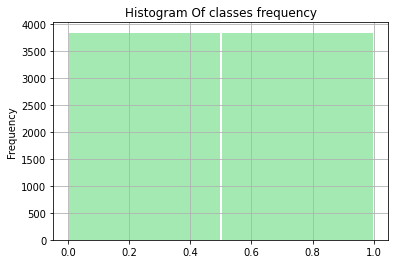

In [53]:
data = data_train.copy()
data['target'] = data_target['target']
classes_ratio = (len(data[data['target'] == 1]) / len(data[data['target'] == 0]))
if classes_ratio <= 0.6:
    print("There exists severe imablance!!")
if classes_ratio >= 0.6 and classes_ratio <= 0.95:
    print("There exists slight imbalance!!")
else:
    print("Dataset balancing looks good!!!")

data['target'].plot.hist(bins=2, alpha=0.96, color=['#A0E8AF', '#FFCF56'], rwidth=0.99, grid=True, histtype='bar', title='Histogram Of classes frequency')

The pca's variance ratio is [0.19628047 0.07724058]


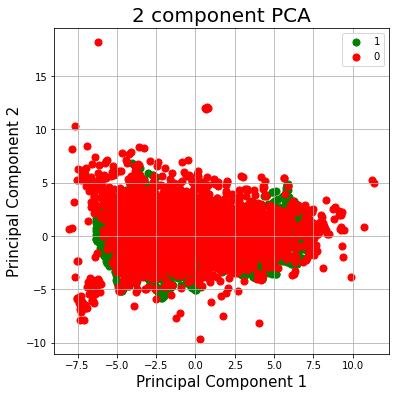

In [54]:
in_train, in_test = standardize_data(data_train, input_test_data)
principal_df, pca = project_data(in_train)
final_df = pd.concat([principal_df, data_target['target']], axis=1)
visualize_data_pca(final_df)
print(f"The pca's variance ratio is {pca.explained_variance_ratio_}")

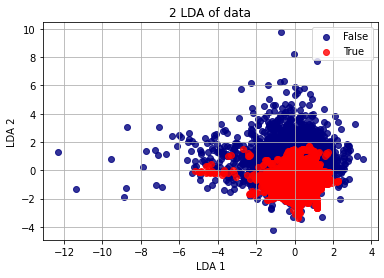



The LDA variance ratios are [0.98256711 0.01743289]



In [85]:
visualize_data_lda(data_train, data_target)

In [55]:
pca = PCA(PCA_VARIANCE)
pca.fit(in_train)
print(f"Num of principal components is {pca.n_components_}")
train_ = pca.transform(in_train)
test_ = pca.transform(in_test)

Num of principal components is 44


In [56]:
train_1, test_1, train_lbl, test_lbl = train_test_split(train_, data_target.target, test_size=1/7.0, random_state=0)
logisticRegr = LogisticRegression(solver = 'lbfgs')
logisticRegr.fit(train_1, train_lbl)
print("The prediction score on test: " + str(logisticRegr.score(test_1, test_lbl)))
print("The prediction score on train: "+ str(logisticRegr.score(train_1, train_lbl)))

The prediction score on test: 0.7374658158614403
The prediction score on train: 0.7331712505698222


In [58]:
from keras import layers, models, optimizers, losses, metrics, regularizers


NUM_VALIDATION: int = int(len(train_) * 0.2)

train_1, test_1, train_lbl, test_lbl = train_test_split(train_, data_target.target, test_size=1/5.0, random_state=0)
x_validation = train_1[:NUM_VALIDATION]
x_partial_train = train_1[NUM_VALIDATION:]
y_validation = train_lbl[:NUM_VALIDATION]
y_partial_train = train_lbl[NUM_VALIDATION:]

metrics_ = [
    metrics.FalseNegatives(name="fn"),
    metrics.FalsePositives(name="fp"),
    metrics.TrueNegatives(name="tn"),
    metrics.TruePositives(name="tp"),
    metrics.Precision(name="precision"),
    metrics.Recall(name="recall"),
    metrics.AUC(name='auc'),
    metrics.AUC(name='prc', curve='PR')
]


def dl_model() -> models.Model:
    model = models.Sequential()
    model.add(layers.Dense(16, activation="relu", input_shape=(train_1.shape[-1],)))
    # model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid', bias_initializer=bias_initializer))
    model.compile(optimizer=optimizers.Adam(lr=1e-3),
                    loss='binary_crossentropy',
                    metrics=metrics_)
    return model


def regularized_dl_model() -> models.Model:
    model = models.Sequential()
    model.add(layers.Dense(16, activation="relu", input_shape=(train_1.shape[-1],)))
    model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.003), activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.003), activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=metrics_)
    return model

In [60]:
model = dl_model()
model.fit(x_partial_train, y_partial_train,
        epochs=500,
        batch_size=32,
        verbose=2,
        validation_data=(x_validation, y_validation),
        shuffle=True)

print("\n")
model.summary()
print("\n")
print(f"score on test:  {str(model.evaluate(test_1, test_lbl)[1])}\n")
print(f"score on train: {str(model.evaluate(train_1, train_lbl)[1])}\n")

0e+00 - fp: 0.0000e+00 - tn: 2278.0000 - tp: 2329.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.3376 - val_fn: 1.0000 - val_fp: 53.0000 - val_tn: 760.0000 - val_tp: 721.0000 - val_precision: 0.9315 - val_recall: 0.9986 - val_auc: 0.9780 - val_prc: 0.9529
Epoch 448/500
144/144 - 0s - loss: 1.5214e-05 - fn: 0.0000e+00 - fp: 0.0000e+00 - tn: 2278.0000 - tp: 2329.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.3387 - val_fn: 1.0000 - val_fp: 53.0000 - val_tn: 760.0000 - val_tp: 721.0000 - val_precision: 0.9315 - val_recall: 0.9986 - val_auc: 0.9780 - val_prc: 0.9530
Epoch 449/500
144/144 - 0s - loss: 1.4595e-05 - fn: 0.0000e+00 - fp: 0.0000e+00 - tn: 2278.0000 - tp: 2329.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.3417 - val_fn: 1.0000 - val_fp: 53.0000 - val_tn: 760.0000 - val_tp: 721.0000 - val_precision: 0.9315 - val_recall: 0.9986 - val_auc: 0.9780 - val_prc: 0.9530
Epoch 4

In [ ]:
model_regularized = regularized_dl_model()
model_regularized.fit(x_partial_train, y_partial_train,
        epochs=300,
        batch_size=64,
        verbose=2,
        validation_data=(x_validation, y_validation))

print("\n")
model_regularized.summary()
print("\n")
print(f"score on test:  {str(model_regularized.evaluate(test_1, test_lbl)[1])}\n")
print(f"score on train:  {str(model_regularized.evaluate(train_1, train_lbl)[1])}\n")

In [61]:
predictions = model.predict_classes(test_)
test_y = pd.DataFrame(predictions, columns=['target'])
test_y['Unnamed: 0'] = out_train_data['Unnamed: 0']
test_y = test_y[['Unnamed: 0', 'target']]
test_y.to_csv('test_y.csv')
test_y.head(8) 
sum(test_y['target'])

/home/salar/Documents/Projects/Advanced-Deep-Learning/adl/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


290